In [4]:
import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
os.environ[
    'XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/usr/local/cuda'

from absl import app
from absl import flags
import matplotlib.pyplot as plt
import pickle
import jax
import jax.numpy as jnp
import jax_cosmo as jc
from tqdm import tqdm
from jax.experimental.ode import odeint
from base import PRNGSequence
from jaxpm.painting import cic_paint, cic_read
from pm import make_neural_ode_fn
from kernels import fftk, gradient_kernel, invlaplace_kernel as laplace_kernel, longrange_kernel
from nn import NeuralSplineFourierFilter  # the Flax version
from jaxpm.utils import power_spectrum
import glob
from stellar_nn import StarCNN
#import partial

import readgadget
import optax
from functools import partial

from flax import linen as nn
from flax.training import train_state

import jax.numpy as jnp
import jax_cosmo as jc

from distributed import fft3d, ifft3d, normal_field
from jaxpm.growth import (dGf2a, dGfa, growth_factor, growth_factor_second,
                          growth_rate, growth_rate_second)
from jaxpm.kernels import (PGD_kernel, fftk, gradient_kernel,
                           invlaplace_kernel, longrange_kernel)
from jaxpm.painting import cic_paint, cic_read
from stellar_nn import StarCNN

from flax.training import train_state

from jaxpm.pm import linear_field, lpt, make_ode_fn

In [13]:
'''
def make_nn_stellar_ode_fn(model, mesh_shape):

    def neural_stellarbody_ode(state, a, cosmo, params):
        """
        state is (position, velocities, density)
        """

        pos, vel, den = state
        delta = cic_paint(jnp.zeros(mesh_shape), pos)
        print(delta.shape, pos.shape, vel.shape)
        delta_k = jnp.fft.rfftn(delta)
        #print(delta_k.shape)
        kvec = fftk(delta.shape)

        # gravitational potential calc
        pot_k = delta_k * invlaplace_kernel(kvec) * longrange_kernel(kvec,
                                                                     r_split=0)

        # gravitational force calc
        forces = jnp.stack([
            cic_read(jnp.fft.irfftn(-gradient_kernel(kvec, i) * pot_k), pos)
            for i in range(3)
        ],
                           axis=-1)

        forces = forces * 1.5 * cosmo.Omega_m

        #delta_den = cic_paint(jnp.zeros(mesh_shape), den) # evolved stellar field
        delta_den = cic_paint(jnp.zeros(mesh_shape), pos, weight=den) 
        sff =  delta_den**2
        #sff = StarCNN(delta, delta_den) # star formation field? placeholder as I don't think this is right
        div = sff / delta 

        ddden = cic_read(div, delta) # delta density
        print("dden", ddden)
        # position update
        dpos = 1. / (a**3 * jnp.sqrt(jc.background.Esqr(cosmo, a))) * vel

        # velovity update 
        dvel = 1. / (a**2 * jnp.sqrt(jc.background.Esqr(cosmo, a))) * forces

        return dpos, dvel, ddden

    return neural_stellarbody_ode
'''

'\ndef make_nn_stellar_ode_fn(model, mesh_shape):\n\n    def neural_stellarbody_ode(state, a, cosmo, params):\n        """\n        state is (position, velocities, density)\n        """\n\n        pos, vel, den = state\n        delta = cic_paint(jnp.zeros(mesh_shape), pos)\n        print(delta.shape, pos.shape, vel.shape)\n        delta_k = jnp.fft.rfftn(delta)\n        #print(delta_k.shape)\n        kvec = fftk(delta.shape)\n\n        # gravitational potential calc\n        pot_k = delta_k * invlaplace_kernel(kvec) * longrange_kernel(kvec,\n                                                                     r_split=0)\n\n        # gravitational force calc\n        forces = jnp.stack([\n            cic_read(jnp.fft.irfftn(-gradient_kernel(kvec, i) * pot_k), pos)\n            for i in range(3)\n        ],\n                           axis=-1)\n\n        forces = forces * 1.5 * cosmo.Omega_m\n\n        #delta_den = cic_paint(jnp.zeros(mesh_shape), den) # evolved stellar field\n        de

In [14]:
'''
def neural_stellarbody_ode(state, a, cosmo, params):
        """
        state is (position, velocities, density)
        """

        pos, vel, den = state
        delta = cic_paint(jnp.zeros(mesh_shape), pos)
        print(delta.shape, pos.shape, vel.shape)
        delta_k = jnp.fft.rfftn(delta)
        #print(delta_k.shape)
        kvec = fftk(delta.shape)

        # gravitational potential calc
        pot_k = delta_k * invlaplace_kernel(kvec) * longrange_kernel(kvec,
                                                                     r_split=0)

        # gravitational force calc
        forces = jnp.stack([
            cic_read(jnp.fft.irfftn(-gradient_kernel(kvec, i) * pot_k), pos)
            for i in range(3)
        ],
                           axis=-1)

        forces = forces * 1.5 * cosmo.Omega_m

        #delta_den = cic_paint(jnp.zeros(mesh_shape), den) # evolved stellar field
        delta_den = cic_paint(jnp.zeros(mesh_shape), pos, weight=den) 
        sff =  delta_den**2
        #sff = StarCNN(delta, delta_den) # star formation field? placeholder as I don't think this is right
        div = sff / delta 

        ddden = cic_read(div, delta) # delta density
        print("dden", ddden)
        # position update
        dpos = 1. / (a**3 * jnp.sqrt(jc.background.Esqr(cosmo, a))) * vel

        # velovity update 
        dvel = 1. / (a**2 * jnp.sqrt(jc.background.Esqr(cosmo, a))) * forces

        return dpos, dvel, ddden

'''

'\ndef neural_stellarbody_ode(state, a, cosmo, params):\n        """\n        state is (position, velocities, density)\n        """\n\n        pos, vel, den = state\n        delta = cic_paint(jnp.zeros(mesh_shape), pos)\n        print(delta.shape, pos.shape, vel.shape)\n        delta_k = jnp.fft.rfftn(delta)\n        #print(delta_k.shape)\n        kvec = fftk(delta.shape)\n\n        # gravitational potential calc\n        pot_k = delta_k * invlaplace_kernel(kvec) * longrange_kernel(kvec,\n                                                                     r_split=0)\n\n        # gravitational force calc\n        forces = jnp.stack([\n            cic_read(jnp.fft.irfftn(-gradient_kernel(kvec, i) * pot_k), pos)\n            for i in range(3)\n        ],\n                           axis=-1)\n\n        forces = forces * 1.5 * cosmo.Omega_m\n\n        #delta_den = cic_paint(jnp.zeros(mesh_shape), den) # evolved stellar field\n        delta_den = cic_paint(jnp.zeros(mesh_shape), pos, weight

In [16]:
mesh_shape = [64, 64, 64]
box_size = [64., 64., 64.]
snapshots = jnp.array([0.1, 0.5, 1.0])

# Create a small function to generate the matter power spectrum
k = jnp.logspace(-4, 1, 128)
pk = jc.power.linear_matter_power(jc.Planck15(Omega_c=0.2, sigma8=0.8), k)
pk_fn = lambda x: jnp.interp(x.reshape([-1]), k, pk).reshape(x.shape)

# Create initial conditions and particles
initial_conditions = linear_field(mesh_shape, box_size, pk_fn, seed=jax.random.PRNGKey(0))
particles = jnp.stack(jnp.meshgrid(*[jnp.arange(s) for s in mesh_shape]),axis=-1).reshape([-1,3])

# Initial displacement
cosmo = jc.Planck15(Omega_c=0.2, sigma8=0.8)
dx, p, f = lpt(cosmo, initial_conditions, particles, a=0.1)

res = odeint(make_ode_fn(mesh_shape), [particles + dx, p], snapshots, cosmo, rtol=1e-8, atol=1e-8)

/home/lszemraj/miniconda3/envs/jax-gpu/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:121: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


In [17]:
res[0].shape

(3, 262144, 3)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


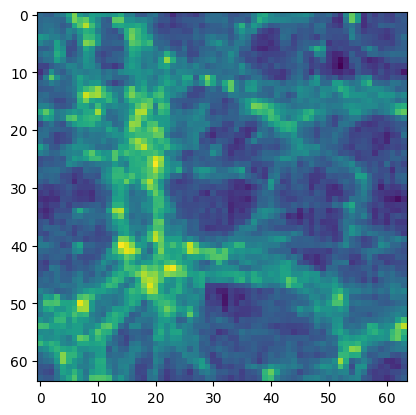

In [11]:
%pylab inline
#plt.plot(jnp.log10(cic_paint(jnp.zeros(mesh_shape) ,res[0][-1]) + 1)[0])
field = (cic_paint(jnp.zeros(mesh_shape), res[0][-1]))
imshow(np.log(field.sum(axis=0)))
plt.savefig("images/stellarfield.png")

# Forward model (using CNN)

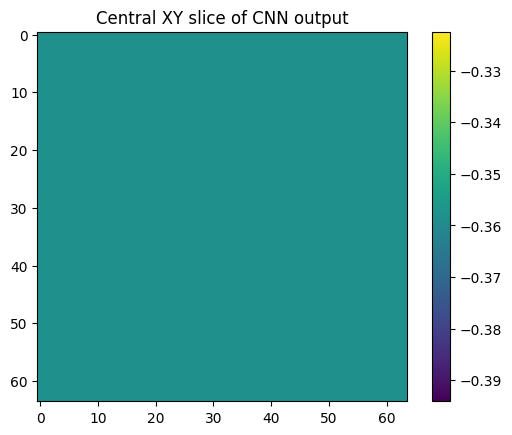

Output shape: (1, 64, 64, 64, 1)
NaNs in output? False
Infs in output? False
Output mean: -0.35827956
Output std: 0.0


In [6]:
import jax
import jax.numpy as jnp


model = StarCNN(num_channels=1, num_layers=2, kernel_size=3)
rng = jax.random.PRNGKey(0)
input_shape = (1, 64, 64, 64, 1)  # (batch, D, H, W, channels)
dummy_input = jnp.ones(input_shape)

params = model.init(rng, dummy_input)
output = model.apply(params, dummy_input)

plt.imshow(output[0, 32, :, :, 0], cmap='viridis')
plt.title("Central XY slice of CNN output")
plt.colorbar()
plt.show()

print("Output shape:", output.shape)
print("NaNs in output?", jnp.isnan(output).any())
print("Infs in output?", jnp.isinf(output).any())
print("Output mean:", output.mean())
print("Output std:", output.std())


In [7]:
def make_nn_stellar_ode_fn(mesh_shape, model, params):
    def neural_stellarbody_ode(state, a, cosmo):
        pos, vel, den = state

        delta = cic_paint(jnp.zeros(mesh_shape), pos)
        delta_k = jnp.fft.rfftn(delta)
        kvec = fftk(delta.shape)

        pot_k = delta_k * invlaplace_kernel(kvec) * longrange_kernel(kvec, r_split=0)

        forces = jnp.stack([
            cic_read(jnp.fft.irfftn(-gradient_kernel(kvec, i) * pot_k), pos)
            for i in range(3)
        ], axis=-1)

        forces = forces * 1.5 * cosmo.Omega_m

        # CNN input
        delta_cnn_input = delta[None, ..., None]  # shape: (1, 64, 64, 64, 1)
        sff = model.apply(params, delta_cnn_input)[0, ..., 0]  # shape: (64, 64, 64)

        dpos = 1. / (a**3 * jnp.sqrt(jc.background.Esqr(cosmo, a))) * vel
        dvel = 1. / (a**2 * jnp.sqrt(jc.background.Esqr(cosmo, a))) * forces

        return dpos, dvel, sff  # returns new state tuple

    return neural_stellarbody_ode


In [5]:
N = 128**3  # or however many particles you're simulating
#positions = jax.random.uniform(rng, (N, 3), minval=0.0, maxval=64.0)  # if mesh is 64³
#velocities = jnp.zeros_like(positions) 
#initial_density = jnp.zeros(mesh_shape)

mesh_shape = [64, 64, 64]
box_size = [64., 64., 64.]
snapshots = jnp.array([0.1, 0.5, 1.0])

k = jnp.logspace(-4, 1, 128)
pk = jc.power.linear_matter_power(jc.Planck15(Omega_c=0.2, sigma8=0.8), k)
pk_fn = lambda x: jnp.interp(x.reshape([-1]), k, pk).reshape(x.shape)

initial_conditions = linear_field(mesh_shape, box_size, pk_fn, seed=jax.random.PRNGKey(0))
particles = jnp.stack(jnp.meshgrid(*[jnp.arange(s) for s in mesh_shape]),axis=-1).reshape([-1,3])
cosmo = jc.Planck15(Omega_c=0.2, sigma8=0.8)

dx, p, f = lpt(cosmo, initial_conditions, particles, a=0.1)

initial_pos = particles + dx          # shape (N, 3)
initial_vel = p                       # shape (N, 3)
initial_den = jnp.zeros(mesh_shape)   # shape (64, 64, 64)

initial_state = (initial_pos, initial_vel, initial_den)

#initial_state = (positions, velocities, initial_density)


mesh_shape = (64, 64, 64)
ode_fn = make_nn_stellar_ode_fn(mesh_shape, model, params)
result = odeint(ode_fn, initial_state, snapshots, cosmo)

print("output shape:", result[-1][-1].shape)
print("Mean density:", result[-1][-1].mean())

output shape: (64, 64, 64)
Mean density: -0.00372235


# Training code

In [27]:
def make_nn_stellar_ode_fn(mesh_shape, model, params):

    def neural_stellarbody_ode(state, a, cosmo):
        """
        state is (position, velocities, density)
        """

        pos, vel, den = state
        delta = cic_paint(jnp.zeros(mesh_shape), pos)
        print(delta.shape, pos.shape, vel.shape)
        delta_k = jnp.fft.rfftn(delta)
        #print(delta_k.shape)
        kvec = fftk(delta.shape)

        # gravitational potential calc
        pot_k = delta_k * invlaplace_kernel(kvec) * longrange_kernel(kvec,
                                                                     r_split=0)

        #  correction filter
        kk = jnp.sqrt(sum((ki / jnp.pi)**2 for ki in kvec))

        # gravitational force calc
        forces = jnp.stack([
            cic_read(jnp.fft.irfftn(-gradient_kernel(kvec, i) * pot_k), pos)
            for i in range(3)
        ],
                           axis=-1)

        forces = forces * 1.5 * cosmo.Omega_m
        
        delta_cnn_input = delta[None, ..., None]  # shape: (1, 64, 64, 64, 1) 
        sff = model.apply(params, delta_cnn_input)[0, ..., 0]

        #sff = 0.0001*delta**2.0 # star formation field? placeholder as I don't think this is right
        # position update
        dpos = 1. / (a**3 * jnp.sqrt(jc.background.Esqr(cosmo, a))) * vel

        # velovity update 
        dvel = 1. / (a**2 * jnp.sqrt(jc.background.Esqr(cosmo, a))) * forces

        return dpos, dvel, sff
    
    return neural_stellarbody_ode

In [28]:
#mesh_shape = [64, 64, 64]

#res = odeint(make_nn_stellar_ode_fn(mesh_shape), [particles + dx, p,jnp.zeros((64,64,64))], snapshots, cosmo, rtol=1e-8, atol=1e-8)

In [30]:
############## TRAINING CODE
#@jax.jit(static_argnames=["model"])
def loss_fn(params, nn_model, initial_state, snapshots, target, cosmo):
    ode_fn = make_nn_stellar_ode_fn(mesh_shape, nn_model, params)
    result = odeint(ode_fn, initial_state, snapshots, cosmo, rtol=1e-5, atol=1e-5)
    pred_density = result[-1][-1]  # final stellar density
    return jnp.mean((pred_density - target)**2)  # MSE loss

#@jax.jit
#@jax.jit(static_argnames=["nn_model"])
def train_step(params, model, initial_state, snapshots, target, cosmo):
    grads = jax.grad(loss_fn)(params, model, initial_state, snapshots, target, cosmo)
    return jax.tree_util.tree_map(lambda p, g: p - 1e-3 * g, params, grads)  # manual SGD


loss_fn = jax.jit(loss_fn, static_argnames=["nn_model"])
train_step = jax.jit(train_step, static_argnames=["model"])


In [36]:
camels_baseline = np.load("/gpfs02/work/diffusion/gridsMstar/Grids_Mstar_IllustrisTNG_CV_128_z=0.0.npy")
camels_baseline_64 = camels_baseline.reshape(27, 64, 2, 64, 2, 64, 2).mean(axis=(2, 4, 6))

In [32]:
imshow(np.log10(camels_baseline[0].sum(axis=0)+1),vmin=10)

NameError: name 'imshow' is not defined

In [33]:
'''
def train_step_fn(loss_fn):
    def train_step(params, initial_state, snapshots, target, cosmo):
        grads = jax.grad(loss_fn)(params, initial_state, snapshots, target, cosmo)
        return jax.tree_util.tree_map(lambda p, g: p - 1e-3 * g, params, grads)
    return jax.jit(train_step)  # no static_argnames needed now!

def make_loss_fn(nn_model, mesh_shape):
    def loss_fn(params, initial_state, snapshots, target, cosmo):
        ode_fn = make_ode_fn(nn_model, params, mesh_shape)
        result = odeint(ode_fn, initial_state, snapshots, cosmo, rtol=1e-5, atol=1e-5)
        pred_density = result[-1][-1]  # final stellar density
        return jnp.mean((pred_density - target)**2)  # MSE loss
    return jax.jit(loss_fn)



rng = jax.random.PRNGKey(0)
mesh_shape = (64, 64, 64)
model = StarCNN(num_channels=1, num_layers=2, kernel_size=3)

dummy_input = jnp.ones((1, 64, 64, 64, 1))  # batch=1, channels=1
params = model.init(rng, dummy_input)
#params = model.init(rng, (particles + dx, p, jnp.zeros(mesh_shape)), 0.1, cosmo)

initial_state = (particles + dx, p, jnp.zeros(mesh_shape))
target = camels_baseline 
snapshots = jnp.array([0.1, 0.5, 1.0])

loss_fn = make_loss_fn(model, mesh_shape)
train_step = train_step_fn(loss_fn)

for epoch in range(100):
    params = train_step(params, initial_state, snapshots, target, cosmo)
    if epoch % 10 == 0:
        loss_val = loss_fn(params, initial_state, snapshots, target, cosmo)
        print(f"Epoch {epoch}: Loss = {loss_val:.6f}")
'''

'\ndef train_step_fn(loss_fn):\n    def train_step(params, initial_state, snapshots, target, cosmo):\n        grads = jax.grad(loss_fn)(params, initial_state, snapshots, target, cosmo)\n        return jax.tree_util.tree_map(lambda p, g: p - 1e-3 * g, params, grads)\n    return jax.jit(train_step)  # no static_argnames needed now!\n\ndef make_loss_fn(nn_model, mesh_shape):\n    def loss_fn(params, initial_state, snapshots, target, cosmo):\n        ode_fn = make_ode_fn(nn_model, params, mesh_shape)\n        result = odeint(ode_fn, initial_state, snapshots, cosmo, rtol=1e-5, atol=1e-5)\n        pred_density = result[-1][-1]  # final stellar density\n        return jnp.mean((pred_density - target)**2)  # MSE loss\n    return jax.jit(loss_fn)\n\n\n\nrng = jax.random.PRNGKey(0)\nmesh_shape = (64, 64, 64)\nmodel = StarCNN(num_channels=1, num_layers=2, kernel_size=3)\n\ndummy_input = jnp.ones((1, 64, 64, 64, 1))  # batch=1, channels=1\nparams = model.init(rng, dummy_input)\n#params = model.ini

In [38]:
mesh_shape = [64, 64, 64]
box_size = [64., 64., 64.]
snapshots = jnp.array([0.1, 0.5, 1.0])

k = jnp.logspace(-4, 1, 128)
pk = jc.power.linear_matter_power(jc.Planck15(Omega_c=0.2, sigma8=0.8), k)
pk_fn = lambda x: jnp.interp(x.reshape([-1]), k, pk).reshape(x.shape)

initial_conditions = linear_field(mesh_shape, box_size, pk_fn, seed=jax.random.PRNGKey(0))
particles = jnp.stack(jnp.meshgrid(*[jnp.arange(s) for s in mesh_shape]),axis=-1).reshape([-1,3])
cosmo = jc.Planck15(Omega_c=0.2, sigma8=0.8)
dx, p, f = lpt(cosmo, initial_conditions, particles, a=0.1)

rng = jax.random.PRNGKey(0)
mesh_shape = (64, 64, 64)
model = StarCNN(num_channels=1, num_layers=2, kernel_size=3)

dummy_input = jnp.ones((1, 64, 64, 64, 1))  # batch=1, channels=1
params = model.init(rng, dummy_input)
#params = model.init(rng, (particles + dx, p, jnp.zeros(mesh_shape)), 0.1, cosmo)

initial_state = (particles + dx, p, jnp.zeros(mesh_shape))
target = camels_baseline_64[0]
snapshots = jnp.array([0.1, 0.5, 1.0])


In [ ]:
losses = []

for epoch in range(100):
    params = train_step(params, model, initial_state, snapshots, target, cosmo)
    if epoch % 10 == 0:
        loss_val = loss_fn(params, model, initial_state, snapshots, target, cosmo)
        print(f"Epoch {epoch}: Loss = {loss_val:.6f}")
        losses.append(float(loss_val))

out_path = "training/starcnn_params.pkl"
out_dir  = os.path.dirname(out_path)

if out_dir and not os.path.exists(out_dir):
    os.makedirs(out_dir, exist_ok=True)

with open(out_path, "wb") as f:
    pickle.dump({"params": params}, f)

print(f"Saved trained params to {out_path}")
